In [1]:
import findspark
findspark.init()


In [2]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

from pyspark.sql.functions import *
from pyspark.sql import functions as f
import pyspark
from pyspark.ml.param import Param, Params
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
import pyspark
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
import matplotlib
import matplotlib.pyplot as plt
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
import atexit
from numpy import array
import numpy as np
import datetime
from pyspark.sql.functions import isnan


In [3]:
spark = SparkSession.builder.master("local[2]").appName("Google playstore app rating prediction").getOrCreate()

In [4]:
df = spark.read.format("csv").option("header",True).option("inferSchema",True).load("C:\\Users\\Jaisriram\\Desktop\\desktop\\bigdata\\examples\\googleplaystore.csv")

df.printSchema()
df.show()
df.count()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)

+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------------+------------------+------------+
|                 App|      Category|Rating|Reviews|Size|   Installs|Type|Price|Content Rating|              Genres|      Last Updated|       Current Ver| Android Ver|
+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------------+--------

10841

In [5]:
df=df.dropDuplicates()
df.count()

10358

In [6]:
df.select([count(when(isnull(c) | isnan(c) , c)).alias(c) for c in df.columns]).show()


+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|App|Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|Genres|Last Updated|Current Ver|Android Ver|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|  0|       0|  1465|      0|   0|       0|   1|    0|             1|     0|           0|          8|          3|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+



In [7]:
from pyspark.sql.types import IntegerType , FloatType
df = df.withColumn("Rating", df["Rating"].cast(FloatType()))
#df = df.withColumn("Type", df["Type"].cast(IntegerType()))
df.printSchema()
df.count()
#df.show(1000)

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: float (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)



10358

In [8]:
df.select([count(when(isnull(c) | isnan(c) , c)).alias(c) for c in df.columns]).show()
df.count()

+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|App|Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|Genres|Last Updated|Current Ver|Android Ver|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|  0|       0|  1467|      0|   0|       0|   1|    0|             1|     0|           0|          8|          3|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+



10358

In [9]:
num_cols = [col_type[0] for col_type in filter(lambda dtype: dtype[1] in {"bigint", "double", "int","float"}, df.dtypes)]
### Compute a dict with <col_name, median_value>
median_dict = dict()
for c in num_cols:
   median_dict[c] = df.stat.approxQuantile(c, [0.5], 0.001)[0]
df = df.na.fill(median_dict)
df.select([count(when(isnull(c) | isnan(c) , c)).alias(c) for c in df.columns]).show()

df.printSchema()
df.count()

+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|App|Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|Genres|Last Updated|Current Ver|Android Ver|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|  0|       0|     0|      0|   0|       0|   1|    0|             1|     0|           0|          8|          3|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: float (nullable = false)
 |-- Reviews: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = t

10358

In [10]:
df = df.withColumn('Size', translate('Size', 'M', ''))
df = df.withColumn('Size', translate('Size', 'k', ''))
df = df.withColumn('Size', translate('Size', '+', ''))
df = df.withColumn('Size', translate('Size', ',', ''))
#df_imputed = df_imputed.withColumn('Size', translate('Size', 'Varies with device', ''))
df = df.withColumn('Installs', translate('Installs', '+', ''))
df = df.withColumn('Installs', translate('Installs', ',', ''))
df = df.withColumn('Price', translate('Price', '$', ''))



In [11]:
#from pyspark.sql.functions import when, lit, col

#df = sc.parallelize([(1, "foo"), (2, "bar")]).toDF(["x", "y"])

#def replace(column, value):
 #   return when(column != value, column).otherwise(lit(None))

#df.withColumn("Size", replace(col("Size"), "Varies with device")).show()


In [12]:
df= df.where(col("Size") != "Varies with device")


#df_imputed.show(30)
#df.show()
df.count()

8833

In [13]:
df= df.where(col("Price") != "Everyone")
df.count()

8832

In [14]:
df= df.where(col("Installs") != "Free")
df.count()

8832

In [ ]:
#df.registerTempTable("da1")
#df2 = spark.sql('select * from da1 where Size=="Varies with device"')
#df2.show()
#df2.count()

In [ ]:

#df_imputed.show(30)
#df.show()
#df1 = spark.sql('select * from da1 where Price=="Everyone"')
#df1.show()
#df1.count()

In [ ]:

#df3 = spark.sql('select * from da1 where Installs=="Free"')
#df3.show()
#df3.count()

In [15]:
df = df.withColumn("Size", df["Size"].cast(FloatType()))
#df = df.withColumn("Installs", df["Installs"].cast(FloatType()))
#df = df.withColumn("Price", df["Price"].cast(FloatType()))
df.printSchema()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: float (nullable = false)
 |-- Reviews: string (nullable = true)
 |-- Size: float (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)



In [16]:
df.select([count(when(isnull(c) | isnan(c) , c)).alias(c) for c in df.columns]).show()

+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|App|Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|Genres|Last Updated|Current Ver|Android Ver|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|  0|       0|     0|      0|   2|       0|   0|    0|             0|     0|           0|          8|          2|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+



In [17]:
df = df.withColumn("Installs", df["Installs"].cast(FloatType()))
df = df.withColumn("Price", df["Price"].cast(FloatType()))
df.printSchema()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: float (nullable = false)
 |-- Reviews: string (nullable = true)
 |-- Size: float (nullable = true)
 |-- Installs: float (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: float (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)



In [18]:
df.select([count(when(isnull(c) | isnan(c) , c)).alias(c) for c in df.columns]).show()

+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|App|Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|Genres|Last Updated|Current Ver|Android Ver|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|  0|       0|     0|      0|   2|       0|   0|    2|             0|     0|           0|          8|          2|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+



In [19]:
df=df.dropna(subset=("Current Ver","Android Ver","Price","Size"))
df.count()

8829

In [20]:
df.select([count(when(isnull(c) | isnan(c) , c)).alias(c) for c in df.columns]).show()
df.count()

+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|App|Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|Genres|Last Updated|Current Ver|Android Ver|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|  0|       0|     0|      0|   0|       0|   0|    0|             0|     0|           0|          7|          2|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+



8829

In [21]:
df=df.where(col("Current Ver") != "NaN")
df.count()

8822

In [22]:
df=df.where(col("Android Ver") != "NaN")
df.count()

8820

In [23]:
df.select([count(when(isnull(c) | isnan(c) , c)).alias(c) for c in df.columns]).show()
#dfdf.count()

+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|App|Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|Genres|Last Updated|Current Ver|Android Ver|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+
|  0|       0|     0|      0|   0|       0|   0|    0|             0|     0|           0|          0|          0|
+---+--------+------+-------+----+--------+----+-----+--------------+------+------------+-----------+-----------+



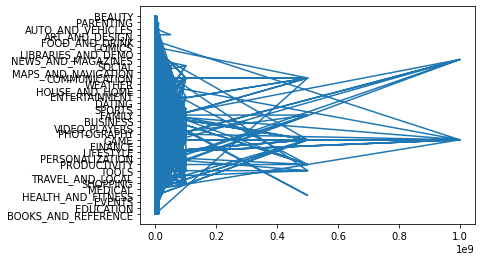

In [24]:
# PLOT PASSENGER NUMBER VS. TRIP COUNTS
#%%local
import matplotlib.pyplot as plt
import pandas
x=df.toPandas()["Installs"].values.tolist()
y=df.toPandas()["Category"].values.tolist()
plt.plot(x,y)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas
x=df.toPandas()["Rating"].values.tolist()
y=df.toPandas()["Category"].values.tolist()
plt.bar(x,y)
plt.show()

In [ ]:
#import seaborn as sns
#test_df = df.toPandas()
#plt.figure(figsize=(7, 5))
#sns.heatmap(test_df.isnull(), cmap='viridis')
#test_df.isnull()

In [ ]:
#import seaborn as sns
#test_df = df.toPandas()
#plt.figure(figsize=(7, 5))
#sns.heatmap(test_df.isnull(), cmap='viridis')
#test_df.isnull()